This notebook descrbies the selection of optimal k-mer length for the "bat" data sets for use in PORT-EK pipeline analysis.
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/bat/[k]mer_indices directories, where [k] denotes the tested k-mer length value. 
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate data sets, previously downloaded in .fasta files, using the following commands from the main PORT-EK directory (the output directories must already exist):
 - python PORTEKfind.py input/bat/bat.fasta output/bat/[k]mer_indices/ --k [k] --group bat
 - python PORTEKfind.py input/bat/EPI_SET_240422qm.fasta output/bat/[k]mer_indices/ --k [k] --group hum

 substituting [k] for the tested k-mer lengths. To replicate the reuslts in the paper, you need to test k values of 5,7,9,11,15,19 and 25 for all sequences.  

You can also run generate_deer_kmers.sh scrpit which will automatically run PORTEKfind for all the options above, this is recommended only if your machine have at least 14 free CPUs.

1. Import necessary libraries and PORT-EK source code:

In [1]:
import sys
import pickle
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True

2. Declare data set specific definitions and functions, and a list of k-mer lengths to be tested.

In [2]:
# PORT-EK parameters
c = 0.05  # This is the conservation thershold used in k-mer rarity filter, other parameters are not used for optimal k selection.
LOW_MEM_MODE = False
# List of k values to test
k_list = [5,7,9,11,13]

# Data set specific definitions and functions

FREQ_COLS = ["M_freq", "nonM_freq"]
AVG_COLS = ["M_avg", "nonM_avg"]
IN_FASTAS = [
    "../input/HIV/prepped/M.fasta",
    "../input/HIV/prepped/nonM.fasta",
]  # only used in low memory mode


def decode_kmer(id: int) -> str:
    decoding = {"00": "A", "01": "C", "10": "G", "11": "T"}
    kmer_bin_string = bin(id)[2:].rjust(30, "0")
    kmer_bin_string = [
        kmer_bin_string[i : i + 2] for i in range(0, len(kmer_bin_string), 2)
    ]
    kmer_seq = "".join([decoding[bits] for bits in kmer_bin_string])

    return kmer_seq

3. Calculate k-mer specificity and efficiency for tested lengths. For definitions and discussion see [reference to our paper]

In [25]:
k_dict = {}
for k in k_list:
    print(f"Calculating specificity and efficiency of {k}-mers.")
    INPUT_PATH = f"../output/HIV/scenario1/"

    kmer_set = set()
    sample_list = []
    kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*_{k}mer_set.pkl")
    sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

    for filename in kmer_set_in_path:
        with open(filename, mode="rb") as in_file:
            partial_set = pickle.load(in_file)
        kmer_set.update(partial_set)

    for filename in sample_list_in_path:
        with open(filename, mode="rb") as in_file:
            partial_list = pickle.load(in_file)
        group = filename.stem.split("_")[0]
        partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
        sample_list.extend(partial_list)

    all_kmer_matrix = pd.DataFrame(
        0, index=list(kmer_set), columns=sample_list, dtype="uint8"
    )
    M_sample_idx = [sample for sample in all_kmer_matrix.columns if sample[0] == "M"]
    nonM_sample_idx = [sample for sample in all_kmer_matrix.columns if "nonM" in sample[0:4] == "nonM"]
    print(f"Done importing sample names and {k}-mers sequences.")

    in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

    for filename in in_path:
        with open(filename, mode="rb") as in_file:
            temp_dict = pickle.load(in_file)
        sample_name = "_".join(filename.stem.split("_")[:-1])
        count_dict = {f"{sample_name}": temp_dict.values()}
        temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
        all_kmer_matrix.update(temp_df)

    all_kmer_matrix.index = all_kmer_matrix.index.map(decode_kmer)

    if LOW_MEM_MODE == True:
        for idx, column in enumerate(FREQ_COLS):
            seq_list = list(SeqIO.parse(IN_FASTAS[idx], format="fasta"))
            for kmer in all_kmer_matrix.index:
                counter = 0
                for seq in seq_list:
                    if kmer in seq.seq:
                        counter += 1
                all_kmer_matrix.loc[kmer, column] = counter/len(seq_list)
    else:
        all_kmer_matrix["M_freq"] = (all_kmer_matrix.loc[:, M_sample_idx]>0).mean(axis=1)
        all_kmer_matrix["nonM_freq"] = (all_kmer_matrix.loc[:, nonM_sample_idx]>0).mean(axis=1)
        
    all_kmer_matrix["M_avg"] = all_kmer_matrix.loc[:, M_sample_idx].mean(axis=1)
    all_kmer_matrix["nonM_avg"] = all_kmer_matrix.loc[:, nonM_sample_idx].mean(axis=1)

    if 0 in all_kmer_matrix.index:
        all_kmer_matrix = all_kmer_matrix.drop(0)
    print(f"Done generating count matrix of all {k}-mers.")

    common_kmer_matrix = portek.filter_kmers(
        all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
    )
    print(f"Done filerting out rare {k}-mers.")

    mean_count = common_kmer_matrix.drop(FREQ_COLS, axis=1).drop(AVG_COLS, axis=1).mean(axis=None)
    common_kmer_matrix[["M_avg_norm", "nonM_avg_norm"]] = (
        common_kmer_matrix[AVG_COLS] / mean_count
    )
    common_kmer_matrix["M_nonM_err_norm"] = (
        common_kmer_matrix["M_avg_norm"] - common_kmer_matrix["nonM_avg_norm"]
    )
    common_kmer_matrix["M_RMSE_norm"] = np.sqrt(
        (common_kmer_matrix["M_nonM_err_norm"]) ** 2
    )
    print(f"Found {len(common_kmer_matrix)} common and {len(all_kmer_matrix)-len(common_kmer_matrix)} rare {k} mers.")
    specificity = common_kmer_matrix["M_RMSE_norm"].quantile(q=0.99)
    efficiency = len(common_kmer_matrix) / len(all_kmer_matrix)
    k_dict[k] = (specificity, efficiency)

    del all_kmer_matrix, common_kmer_matrix
    print(f"Done calculating specificty ({specificity}) and efficiency ({efficiency}) of {k}-mers.")

Calculating specificity and efficiency of 5-mers.
Done importing sample names and 5-mers sequences.
Done generating count matrix of all 5-mers.
Done filerting out rare 5-mers.
Found 1024 common and 0 rare 5 mers.
Done calculating specificty (0.8657818908492865) and efficiency (1.0) of 5-mers.
Calculating specificity and efficiency of 7-mers.
Done importing sample names and 7-mers sequences.
Done generating count matrix of all 7-mers.
Done filerting out rare 7-mers.
Found 13177 common and 3206 rare 7 mers.
Done calculating specificty (3.1854197993567466) and efficiency (0.8043093450527986) of 7-mers.
Calculating specificity and efficiency of 9-mers.
Done importing sample names and 9-mers sequences.
Done generating count matrix of all 9-mers.
Done filerting out rare 9-mers.
Found 51226 common and 178374 rare 9 mers.
Done calculating specificty (6.09205409136575) and efficiency (0.22310975609756098) of 9-mers.
Calculating specificity and efficiency of 11-mers.
Done importing sample names 

4. Plot specificity and efficiency

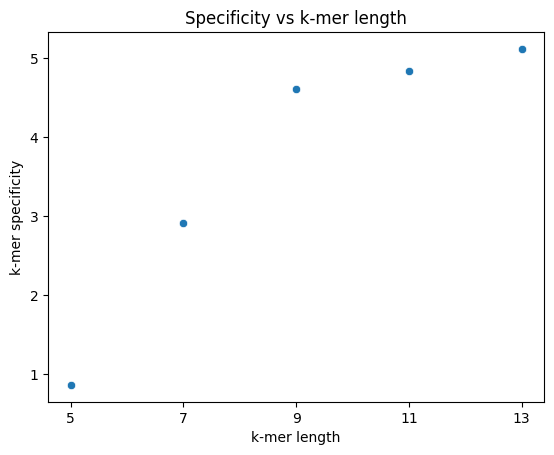

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Specificity vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer specificity")
sns.scatterplot(x=k_list, y=[val[0] for val in k_dict.values()])
plt.show()

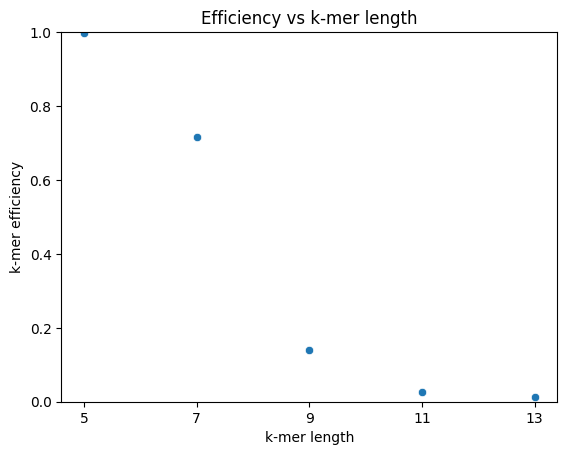

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Efficiency vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer efficiency")
ax.set_ylim(0,1)
sns.scatterplot(x=k_list, y=[val[1] for val in k_dict.values()])
plt.show()